In [1]:
# install if not yet done
using Pkg

# Pkg.add(url="https://github.com/mppmu/BoostFractor.jl.git")
# Pkg.add(url="https://github.com/bergermann/Dragoon.jl.git")
Pkg.update()

    Updating registry at `C:\Users\domin\.julia\registries\General`
┌ Info: The General registry is installed via git. Consider reinstalling it via
│ the newer faster direct from tarball format by running:
│   pkg> registry rm General; registry add General
│ 
└ @ Pkg.Registry C:\Users\domin\.julia\juliaup\julia-1.11.3+0.x64.w64.mingw32\share\julia\stdlib\v1.11\Pkg\src\Registry\Registry.jl:478
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
    Updating git-repo `https://github.com/mppmu/BoostFractor.jl.git`
    Updating git-repo `https://github.com/bergermann/Dragoon.jl.git`
   Installed Xorg_libXcursor_jll ─────── v1.2.4+0
   Installed Xorg_libXi_jll ──────────── v1.8.3+0
   Installed Xorg_xkeyboard_config_jll ─ v2.44.0+0
   Installed LLVMOpenMP_jll ──────────── v18.1.8+0
    Updating `C:\Users\domin\.julia\environments\v1.11\Project.toml`
  [2528b1d8] ~ Dragoon v0.5.0 `https://github.com/bergermann/Dragoon.jl.git#main` ⇒ v0.5.0 `https://github.com/bergermann/Dr

In [2]:
using Dragoon
using Plots
using HDF5

In [8]:
n = 4 # number of discs in the booster
f0 = 25.025e9   # 21, 25, 28
ϵ = 9.0
τ = 2e-3
tand = 3e-5

initdist = findpeak1d(f0,n; granularity=10_000,deviation=0.1,thickness=τ,eps=ϵ,tand=tand) # initial disc configuration

freqs = genFreqs(f0,2000e6; n=10) # optimize on these frequencies
freqsplot = genFreqs(f0,10050e6; n=10000) # plot with these frequencies

booster = AnalyticalBooster(initdist; ndisk=n,ϵ=ϵ,τ=τ,tand=tand)  # physical properties of the booster
booster.wavelength = λ(f0)

hist = initHist(booster,1000,freqs,ObjAnalytical); # stores measurements
#                           ^ length, should be at least n

max boost: 65.87216029187034


1000-element Vector{State}:
 State([0.006014480084503555, 0.01402896016900711, 0.022043440253510665, 0.030057920338014223], -65.84767739733236, Dates.DateTime("0000-01-01T00:00:00"))
 State([0.0, 0.0, 0.0, 0.0], 0.0, Dates.DateTime("0000-01-01T00:00:00"))
 State([0.0, 0.0, 0.0, 0.0], 0.0, Dates.DateTime("0000-01-01T00:00:00"))
 State([0.0, 0.0, 0.0, 0.0], 0.0, Dates.DateTime("0000-01-01T00:00:00"))
 State([0.0, 0.0, 0.0, 0.0], 0.0, Dates.DateTime("0000-01-01T00:00:00"))
 State([0.0, 0.0, 0.0, 0.0], 0.0, Dates.DateTime("0000-01-01T00:00:00"))
 State([0.0, 0.0, 0.0, 0.0], 0.0, Dates.DateTime("0000-01-01T00:00:00"))
 State([0.0, 0.0, 0.0, 0.0], 0.0, Dates.DateTime("0000-01-01T00:00:00"))
 State([0.0, 0.0, 0.0, 0.0], 0.0, Dates.DateTime("0000-01-01T00:00:00"))
 State([0.0, 0.0, 0.0, 0.0], 0.0, Dates.DateTime("0000-01-01T00:00:00"))
 ⋮
 State([0.0, 0.0, 0.0, 0.0], 0.0, Dates.DateTime("0000-01-01T00:00:00"))
 State([0.0, 0.0, 0.0, 0.0], 0.0, Dates.DateTime("0000-01-01T00:00:00"))
 State([0.0

In [10]:
initdist

0.006014480084503555

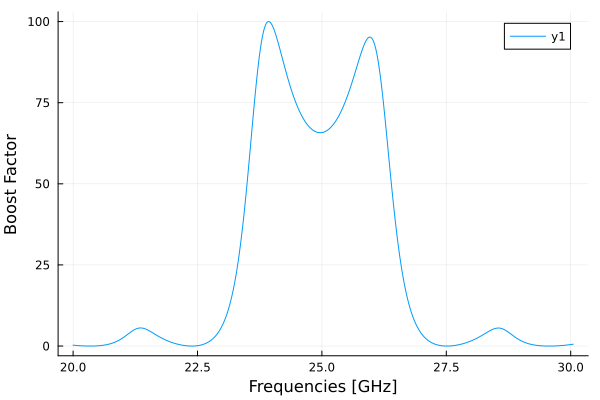

In [9]:
plot(freqsplot/1e9,getBoost1d(booster,freqsplot); ylabel="Boost Factor",xlabel="Frequencies [GHz]")

In [ ]:
trace = nelderMead(booster,hist,freqs,
                    1.,1+2/n,0.75-1/2n,1-1/n,1e-9,1e-9,
                    ObjAnalytical,
                    InitSimplexRegular(1e-4),
                    DefaultSimplexSampler,
                    UnstuckDont;
                    maxiter=Int(1e5),
                    showtrace=true,
                    showevery=100,
                    unstuckisiter=true,)

In [16]:
discnumbers = [4,8]
bandwidths = [10,50,100]
results = []
centerfreqs = [18,21,25,27,30]
ϵ = 9.0
τ = 2e-3
tand = 3e-5

for n in discnumbers
    for cf in centerfreqs
        centerfreq = cf*1e9
        initdist = findpeak1d(centerfreq,n; eps=ϵ,tand=tand,thickness=τ,
            granularity=100_000,deviation=0.2)

        for bw in bandwidths
            if !isdir(joinpath("$(n)discs","$(cf)GHz","$(bw)MHz"))
                mkpath(joinpath("$(n)discs","$(cf)GHz","$(bw)MHz"))
            end

            print("n: $n, cf:$cf GHz, bw: $bw MHz")

            freqs = genFreqs(centerfreq,bw*1e6; n=100)
            freqsplot = genFreqs(centerfreq,1000e6; n=1000)

            booster = AnalyticalBooster(initdist; ndisk=n,ϵ=ϵ,tand=tand,τ=τ)

            hist = initHist(booster,100,freqs,ObjAnalytical);

            trace = nelderMead(booster,hist,freqs,
                        1.,1+2/booster.ndisk,0.75-1/2booster.ndisk,1-1/booster.ndisk,1e-12,1e-12,
                        ObjAnalytical,
                        InitSimplexCoord(1e-4),
                        DefaultSimplexSampler,
                        UnstuckDont;
                        maxiter=Int(50_000),
                        traceevery=50_000,
                        showtrace=false,
                        unstuckisiter=true);

            obj = trace[end].obj[1]
            dist = pos2dist(booster.pos; thickness=τ)
            boost = getBoost1d(booster,freqs)
            ref = getRef1d(booster,freqs)

            println(", obj: ",obj)
            
            p1 = plot(freqsplot/1e9,getBoost1d(booster,freqsplot);
                ylabel="Boost Factor β²",xlabel="Frequencies [GHz]",legend=false)
            vline!(p1,freqs[[1,100]]/1e9; c=:red)
            p2 = plot(freqsplot/1e9,abs.(getRef1d(booster,freqsplot));
                ylabel="Reflectivity |S11|",xlabel="Frequencies [GHz]",legend=false)
            vline!(p2,freqs[[1,100]]/1e9; c=:red)
            p3 = plot(1:n,dist/1e-3; seriestype=:scatter,xlabel="Disc Index [i]",ylabel="Distances [mm]")

            savefig(p1,joinpath("$(n)discs","$(cf)GHz","$(bw)MHz","boost.svg"))
            savefig(p2,joinpath("$(n)discs","$(cf)GHz","$(bw)MHz","ref.svg"))
            savefig(p3,joinpath("$(n)discs","$(cf)GHz","$(bw)MHz","dists.svg"))

            if isfile(joinpath("$(n)discs","$(cf)GHz","$(bw)MHz","data.h5"))
                rm(joinpath("$(n)discs","$(cf)GHz","$(bw)MHz","data.h5"))
            end
            h5write(joinpath("$(n)discs","$(cf)GHz","$(bw)MHz","data.h5"),"data/obj",obj)
            h5write(joinpath("$(n)discs","$(cf)GHz","$(bw)MHz","data.h5"),"data/distances",dist)
            h5write(joinpath("$(n)discs","$(cf)GHz","$(bw)MHz","data.h5"),"data/boost",boost)
            h5write(joinpath("$(n)discs","$(cf)GHz","$(bw)MHz","data.h5"),"data/ref",ref)
            h5write(joinpath("$(n)discs","$(cf)GHz","$(bw)MHz","data.h5"),"data/freqs",freqs)

            for file in readdir(joinpath("$(n)discs","$(cf)GHz","$(bw)MHz"))
                if occursin(".obj",file); rm(joinpath("$(n)discs","$(cf)GHz","$(bw)MHz",file)); end
            end

            open(joinpath("$(n)discs","$(cf)GHz","$(bw)MHz","$(round(Int,obj)).obj"), "w")
        end
    end
end

max boost: 702.4792503496009
n: 4, cf:18 GHz, bw: 10 MHz, obj: -3457.8058245901448
n: 4, cf:18 GHz, bw: 50 MHz, obj: -944.7650968430402
n: 4, cf:18 GHz, bw: 100 MHz, obj: -513.2935591636224
max boost: 404.0701192153889
n: 4, cf:21 GHz, bw: 10 MHz, obj: -1172.5459977281344
n: 4, cf:21 GHz, bw: 50 MHz, obj: -764.5916997562992
n: 4, cf:21 GHz, bw: 100 MHz, obj: -493.3421252580172
max boost: 65.79697946174029
n: 4, cf:25 GHz, bw: 10 MHz, obj: -65.78950253831273
n: 4, cf:25 GHz, bw: 50 MHz, obj: -65.78185602909417
n: 4, cf:25 GHz, bw: 100 MHz, obj: -65.78186249131015
max boost: 181.1718985764108
n: 4, cf:27 GHz, bw: 10 MHz, obj: -234.9145825784649
n: 4, cf:27 GHz, bw: 50 MHz, obj: -230.6435179522043
n: 4, cf:27 GHz, bw: 100 MHz, obj: -221.00897578061057
max boost: 525.7085029715904
n: 4, cf:30 GHz, bw: 10 MHz, obj: -2341.299669661391
n: 4, cf:30 GHz, bw: 50 MHz, obj: -1141.3090334995434
n: 4, cf:30 GHz, bw: 100 MHz, obj: -693.6796705729514
max boost: 6139.7269536012545
n: 8, cf:18 GHz, bw: 